In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple, Dict
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Make sure exercises are in the path
sys.path.append(str(Path.cwd().parent))
from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)


device = t.device("cuda" if t.cuda.is_available() else "cpu")

from superposition_lib import Config, get_angle, create_mask_from_group_members, create_diagonal_mask,Model


In [11]:
n_features = 80
n_hidden = 20
group_size = 5

importance = (1.0 ** t.arange(n_features))
#importance = t.cat([t.tensor([1-0.1*(i+1)/2 for i in range(group_size)])**(j+1) for j in  range(0, n_features, group_size)])
importance = einops.rearrange(importance, "features -> () features")
p_transfer = 0.2

n_instances = 25
inner_goup_distance = t.logspace(-4, 0, n_instances)
#inner_goup_distance = t.linspace(0.1, .51, n_instances)

feature_probability = t.ones(n_instances)*0.4

groupings =[[dict(members=list(range(i, i+group_size)), semantic_distance=igd, p_transfer = p_transfer) for i in range(0, n_features, group_size)] for igd in inner_goup_distance]

#feature_probability = t.ones(n_instances)*0.001
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

cfg = Config(
    n_instances = len(feature_probability.squeeze()),
    n_features = n_features,
    n_hidden = n_hidden,
)

model = Model(
    cfg = cfg,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
    groupings = groupings,
)
#model.optimize(steps=1_000)

In [12]:
model.accuracy_matrix[:,3,3]

tensor([0.4166, 0.4183, 0.4204, 0.4230, 0.4261, 0.4299, 0.4344, 0.4399, 0.4466,
        0.4546, 0.4642, 0.4759, 0.4899, 0.5067, 0.5269, 0.5510, 0.5798, 0.6140,
        0.6544, 0.7017, 0.7566, 0.8190, 0.8874, 0.9562, 1.0000])

In [3]:
plot_features_in_Nd(
    model.W,
    height = 600,
    width = 1400,
    title = "ReLU output model: n_features = 80, d_hidden = 20, I<sub>i</sub> = 0.9<sup>i</sup>",
    subplot_titles = [f"semantic distance = {igd:.2f}" for igd in inner_goup_distance],
)

In [ ]:
group_size = 5
diagonal_mask = t.eye(wtw.shape[1], dtype=t.bool)
group_mask = t.zeros_like(diagonal_mask, dtype=t.bool)
for group_number in range(0, wtw.shape[1], group_size):
    for i in range(group_size):
        for j in range(group_size):
            group_mask[group_number + i, group_number + j] = True
group_mask = group_mask & ~diagonal_mask

others_mask = ~group_mask & ~diagonal_mask

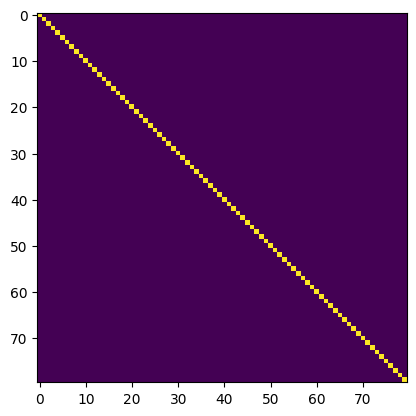

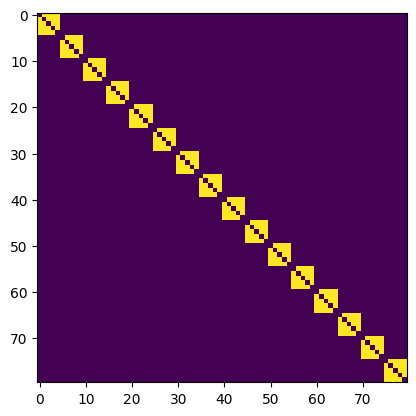

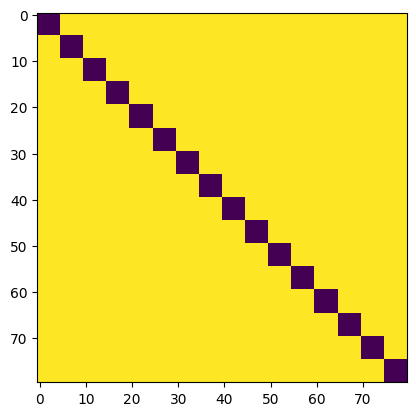

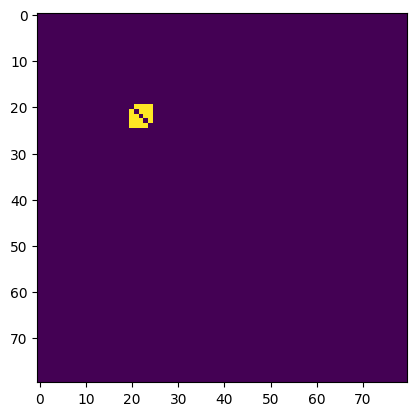

In [41]:
def create_diagonal_mask(n_features: int) -> t.Tensor:
    return t.eye(n_features, dtype=t.bool)
def create_group_mask(n_features: int, group_size: int) -> t.Tensor:
    mask = t.zeros((n_features, n_features), dtype=t.bool)
    for group_number in range(0, n_features, group_size):
        for i in range(group_size):
            for j in range(group_size):
                mask[group_number + i, group_number + j] = True
    return mask & ~create_diagonal_mask(n_features)
def create_others_mask(n_features: int, group_size: int) -> t.Tensor:
    return ~create_group_mask(n_features, group_size) & ~create_diagonal_mask(n_features)
def create_mask_from_group_members(n_features: int, group_members: List[int]) -> t.Tensor:
    mask = t.zeros((n_features, n_features), dtype=t.bool)
    for i in group_members:
        for j in group_members:
            mask[i, j] = True
    return mask & ~create_diagonal_mask(n_features)

n_features = 80
group_size = 5

diagonal_mask = create_diagonal_mask(n_features)
group_mask = create_group_mask(n_features, group_size)
others_mask = create_others_mask(n_features, group_size)

plt.imshow(diagonal_mask)
plt.show()
plt.imshow(group_mask)
plt.show()
plt.imshow(others_mask)
plt.show()

group_members = [20, 21, 22, 23, 24]
mask = create_mask_from_group_members(n_features, group_members)
plt.imshow(mask)
plt.show()

In [39]:
random_matrix = t.randn(80, 80)
random_matrix[diagonal_mask] = 0
random_matrix[group_mask] = 1
random_matrix[others_mask] = 2